In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import mean_squared_error

# set path for image file
file_path = 'bnw.png'  # update this to match your file location

# define range for n values, exploring impact of different sizes
n_values = range(8, 12)

# store images for comparison
original_and_reconstructed_images = []

In [2]:
# encoding from 2d coordinates to 1d hilbert index
def xy2d(n, x, y):
    """
    convert 2d coordinates (x, y) on n x n grid to 1d hilbert curve index.
    n must be power of 2. this function iterates over grid size, applying
    transformations to determine position along hilbert curve.
    """
    d = 0
    s = n // 2
    while s > 0:
        rx = int((x & s) > 0)
        ry = int((y & s) > 0)
        d += s * s * ((3 * rx) ^ ry)
        x, y = rot(s, x, y, rx, ry)
        s //= 2
    return d

In [3]:
# decoding 1d hilbert index to 2d coordinates
def d2xy(n, d):
    """
    convert 1d hilbert curve index to 2d coordinates on n x n grid.
    inverse of xy2d function, reconstructing original position from
    hilbert curve index through iterative transformations.
    """
    x = y = 0
    t = d
    s = 1
    while s < n:
        rx = 1 & (t // 2)
        ry = 1 & (t ^ rx)
        x, y = rot(s, x, y, rx, ry)
        x += s * rx
        y += s * ry
        t //= 4
        s *= 2
    return x, y

In [4]:
# function to rotate grid during hilbert index calculation
def rot(n, x, y, rx, ry):
    """
    rotate and flip 2d grid coordinates based on rx and ry values.
    used in both encoding and decoding hilbert curve to ensure
    coordinates match curve's path.
    """
    if ry == 0:
        if rx == 1:
            x, y = n-1 - x, n-1 - y
        x, y = y, x
    return x, y

In [5]:
# main section for hilbert curve application to image processing
# load image and convert to numpy array
image = Image.open(file_path)
image_array = np.array(image)

# test fidelity of reconstruction across different n values
mse_values = []
for exp_n in n_values:
    n = 2 ** exp_n
    # generate list of 2d coordinates and calculate corresponding hilbert indices
    coords = [(x, y) for y in range(image_array.shape[0]) for x in range(image_array.shape[1])]
    indices = np.array([xy2d(n, x, y) for x, y in coords])

    # reconstruct image from hilbert indices
    reconstructed_image = np.zeros_like(image_array)
    for index, h_index in enumerate(indices):
        x, y = coords[index]
        reconstructed_x, reconstructed_y = d2xy(n, h_index)
        if 0 <= reconstructed_x < image_array.shape[1] and 0 <= reconstructed_y < image_array.shape[0]:
            reconstructed_image[reconstructed_y, reconstructed_x] = image_array[y, x]

    # calculate and record mean squared error for each n
    mse = mean_squared_error(image_array.flatten(), reconstructed_image.flatten())
    mse_values.append(mse)
    print(f"n: 2^{exp_n}, mse: {mse}")

n: 2^8, mse: 90.19412396937574
n: 2^9, mse: 87.94668175795053
n: 2^10, mse: 17.8069324204947
n: 2^11, mse: 0.0


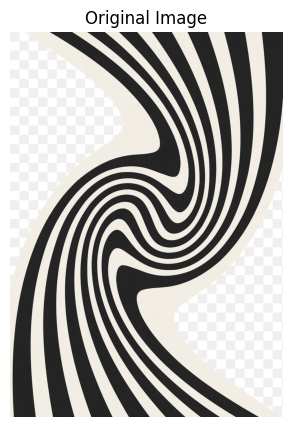

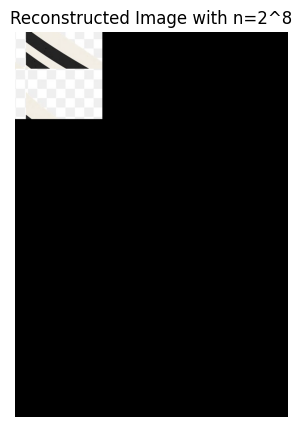

n: 2^8, Compression Rate: 1.50


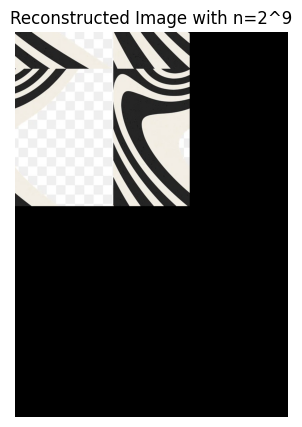

n: 2^9, Compression Rate: 1.33


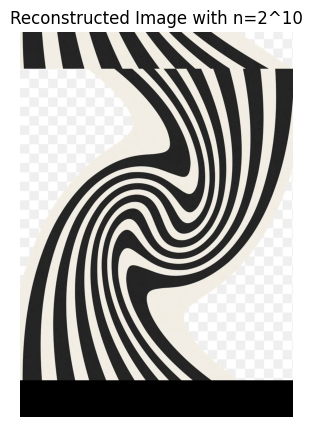

n: 2^10, Compression Rate: 1.20


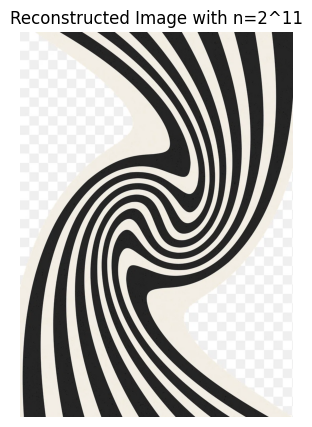

n: 2^11, Compression Rate: 1.09


In [6]:
# assuming image_array is defined and loaded from previous steps
n_values_specific = range(8, 12)  # Specific range for visualization

# Calculate the size of the original image in bits
original_size_bits = image_array.size * 8  # since each pixel is 8 bits

# Create a dictionary to store the compression rates
compression_rates = {}

# Visualize the original image just once at the beginning
plt.figure(figsize=(5, 5))
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Loop through the specified n values to visualize reconstructed images
for exp_n in n_values_specific:
    n = 2 ** exp_n
    # Generate list of 2D coordinates and calculate corresponding Hilbert indices
    coords = [(x, y) for y in range(image_array.shape[0])
              for x in range(image_array.shape[1])]
    indices = np.array([xy2d(n, x, y) for x, y in coords])

    # Reconstruct image from Hilbert indices
    reconstructed_image = np.zeros_like(image_array)
    for index, h_index in enumerate(indices):
        x, y = coords[index]
        reconstructed_x, reconstructed_y = d2xy(n, h_index)
        if 0 <= reconstructed_x < image_array.shape[1] and 0 <= reconstructed_y < image_array.shape[0]:
            reconstructed_image[reconstructed_y,
                                reconstructed_x] = image_array[y, x]

    # Visualize each reconstructed image
    plt.figure(figsize=(5, 5))
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f'Reconstructed Image with n=2^{exp_n}')
    plt.axis('off')
    plt.show()

    # Calculate the size of the compressed image in bits
    # Assuming we're storing indices as integers
    max_index_value = n * n - 1
    bits_per_index = np.ceil(np.log2(max_index_value + 1)).astype(int)
    compressed_size_bits = indices.size * bits_per_index

    # Calculate the compression rate
    compression_rate = original_size_bits / compressed_size_bits
    compression_rates[exp_n] = compression_rate

    # Print out the compression rate for each n
    print(f"n: 2^{exp_n}, Compression Rate: {compression_rate:.2f}")

In [10]:
from pydub import AudioSegment

# Load the MP3 file
file_path = r'hilbert-transform\bbp.mp3'  # Replace with your file path
audio = AudioSegment.from_mp3(file_path)

# Convert to mono and get the raw audio data as a numpy array
samples = np.array(audio.set_channels(1).get_array_of_samples())

# Truncate the samples to the nearest power of two
max_power_of_two = 2**int(np.floor(np.log2(len(samples))))
samples = samples[:max_power_of_two]

# Use a smaller n if the number of samples is less than 2^10, otherwise use 2^10
n = min(2**10, max_power_of_two)

# Generate the Hilbert indices and map to 2D coordinates
hilbert_indices = np.arange(n)
x_coords, y_coords = zip(*[d2xy(n, idx) for idx in hilbert_indices])

# Visualize the waveform data mapped onto 2D Hilbert space
plt.figure(figsize=(10, 10))
plt.scatter(x_coords, y_coords, c=samples, cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title(f'Audio Waveform Mapped onto a 2D Hilbert Curve with n={n}')
plt.xlabel('Hilbert X')
plt.ylabel('Hilbert Y')
plt.grid(True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'hilbert-transform\\bbp.mp3'